### Chapter Stuff

First Example Using Unpooled Models (Non Heirarchial)

In [1]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [1]:
import preliz as pz
import arviz as az
import pymc as pm
import numpy as np
import pandas as pd

df=pd.read_csv('chemical_shifts_theo_exp.csv')
df['diff']=df[['theo','exp']].apply(lambda x: x.theo-x.exp,axis=1)

categories = np.array(pd.unique(df['aa'])) 
diff = df["diff"].values 
idx = pd.Categorical(df["aa"], categories=categories).codes

coords = { 'aa' : categories,'aa_flat':categories[idx]}

with pm.Model(coords=coords) as cs_nh:
    μ=pm.Normal('μ',mu=0,sigma=10,dims='aa') #the dims is essentially same as defining a shape = 19
    σ =pm.HalfNormal('σ',sigma=10,dims='aa')
    y=pm.Normal('y',mu=μ[idx],sigma=σ [idx],observed=diff)
    idata_cs_nh = pm.sample()



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

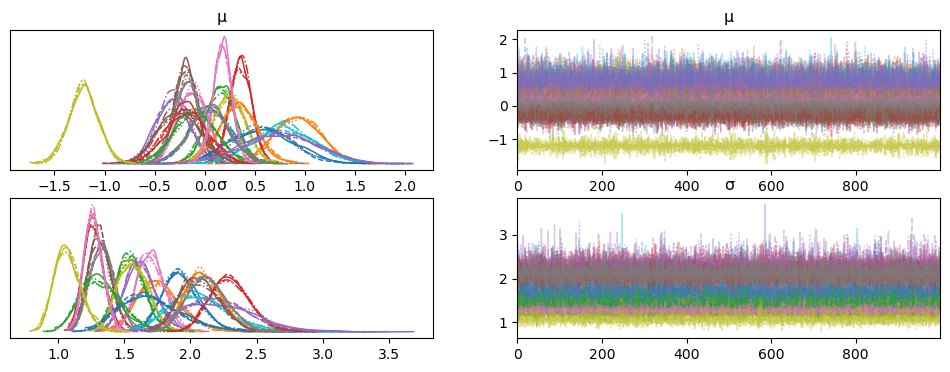

In [2]:
az.plot_trace(idata_cs_nh)

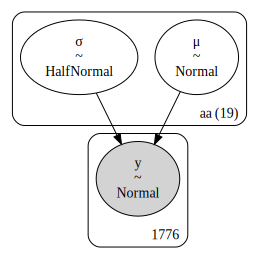

In [3]:
pm.model_to_graphviz(cs_nh)

First Example Using Heirarchial Models

In [4]:
with pm.Model(coords=coords) as cs_h: 
    # hyper_priors 
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10) 
    μ_sd = pm.HalfNormal('μ_sd', 10) 
    # priors 
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 
    # likelihood 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


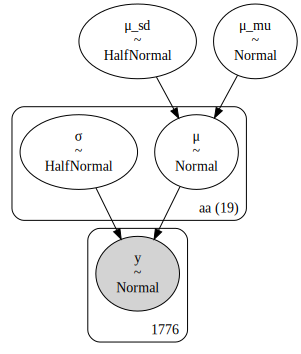

In [5]:
pm.model_to_graphviz(cs_h)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

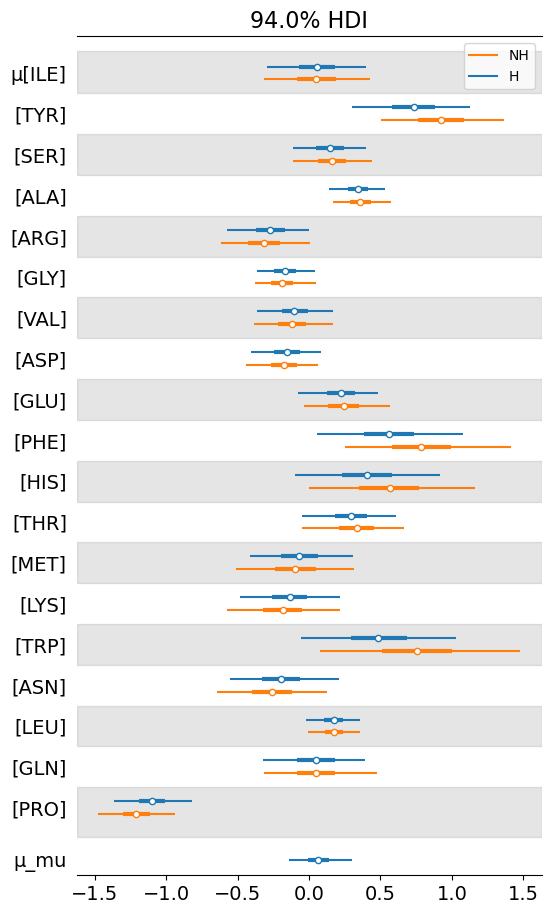

In [7]:
az.plot_forest([idata_cs_h,idata_cs_nh],combined=True,model_names=['H','NH'],var_names=['μ','μ_mu'])

In [48]:
N_samples = [30, 30, 30] 
G_samples = [18, 18, 18] 
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)

print(group_idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [52]:
np.repeat([1,2],[3,5])

array([1, 1, 1, 2, 2, 2, 2, 2])

### Exercise

In [1]:
import preliz as pz
import arviz as az
import pymc as pm
import numpy as np
import pandas as pd

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


2. Repeat the exercise we did with model_h. This time, without a hierarchical structure, use a flat prior such as Beta(α = 1,β = 1). Compare the results of both models.

In [21]:
## Data

N_samples = [30, 30, 30] 
G_samples = [18, 18, 3] 
group_idx = np.repeat(np.arange(len(N_samples)), N_samples) 
data = [] 
for i in range(0, len(N_samples)): 
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [22]:
#Using Flat Prior
with pm.Model() as model_h_flat: 
    # prior 
    θ = pm.Beta('θ', alpha=1, beta=1, shape=len(N_samples)) 
    # likelihood 
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data) 
 
    idata_h_flat = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


array([[<Axes: title={'center': 'θ'}>,
        <Axes: title={'center': 'θ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

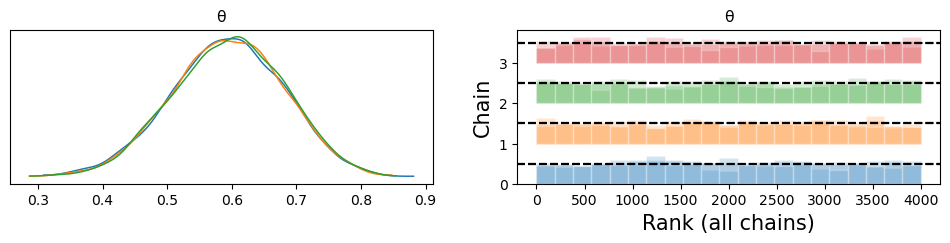

In [13]:
az.plot_trace(idata_h_flat,combined=True,kind='rank_bars')

array([<Axes: title={'center': 'θ\n0'}>, <Axes: title={'center': 'θ\n1'}>,
       <Axes: title={'center': 'θ\n2'}>], dtype=object)

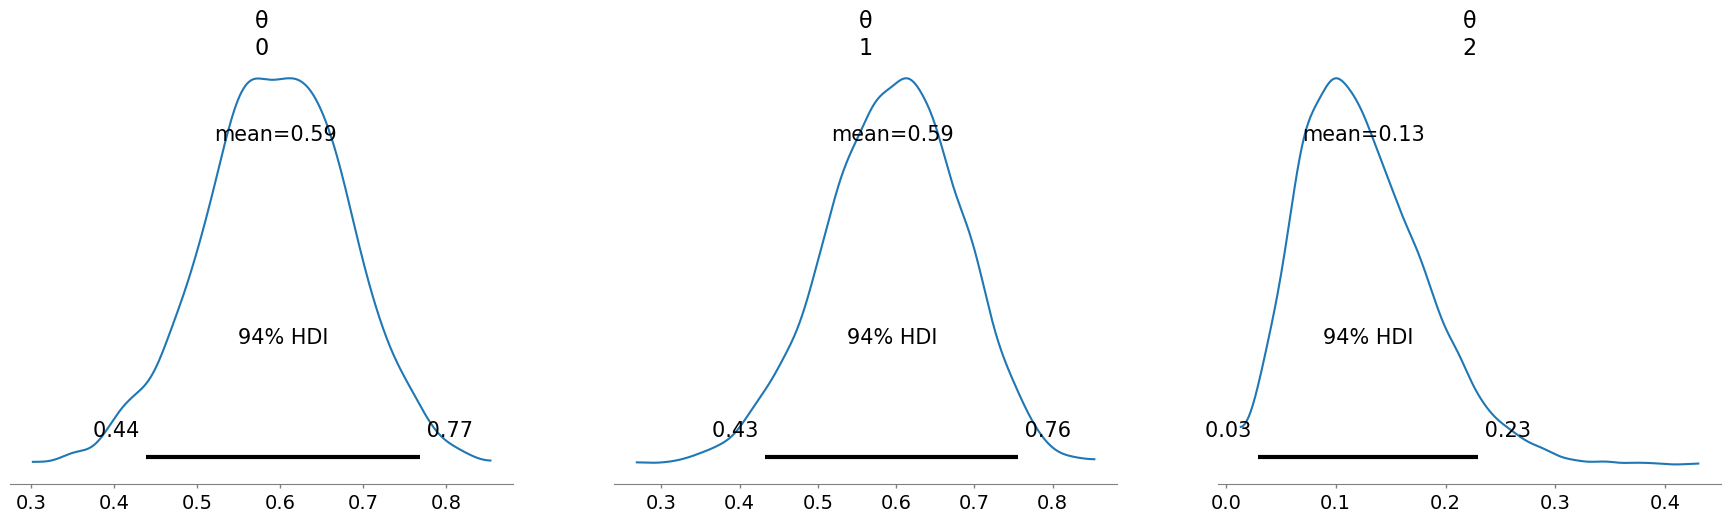

In [23]:
az.plot_posterior(idata_h_flat,hdi_prob=.94)

In [24]:
#Using Individual Hyper Prior
with pm.Model() as model_h: 
    # hypyerpriors 
    μ = pm.Beta('μ', 1, 1) 
    ν = pm.HalfNormal('ν', 10) 
    # prior 
    θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N_samples)) 
    # likelihood 
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data) 
 
    idata_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'ν'}>,
        <Axes: title={'center': 'θ\n0'}>],
       [<Axes: title={'center': 'θ\n1'}>,
        <Axes: title={'center': 'θ\n2'}>, <Axes: >]], dtype=object)

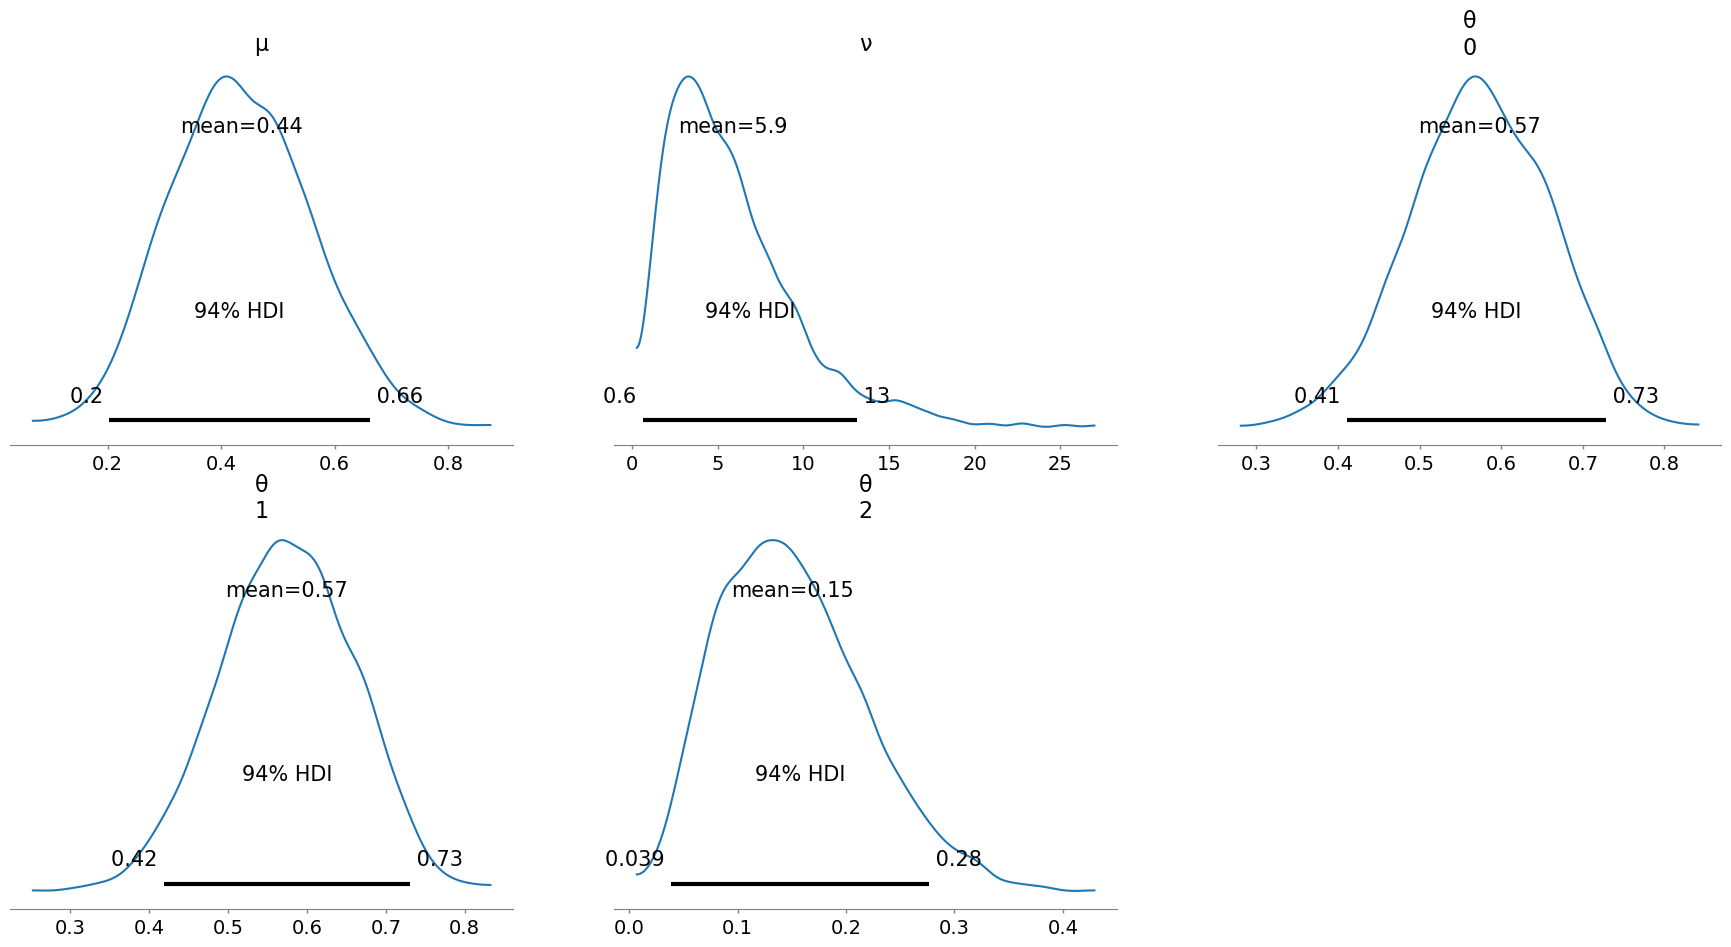

In [25]:
az.plot_posterior(idata_h,hdi_prob=.94)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

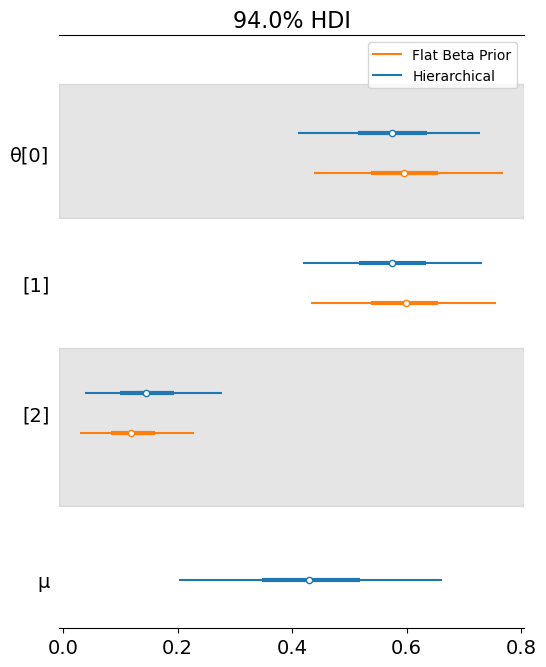

In [28]:
az.plot_forest([idata_h,idata_h_flat],combined=True,model_names=['Hierarchical','Flat Beta Prior'],var_names=['θ','μ'])

Very Minimal Deviation is observed in the forest plots. This is probably due to the fact that the dataset in the groups are very similar and there is not much information shared between the groups in the Heirarchial Model. The entire information is also present in the Flat prior

3. Create a hierarchical version of the tips example from Chapter 2, by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.

In [2]:
tips=pd.read_csv('tips.csv')
tips.head()

categories = np.array(["Thur", "Fri", "Sat", "Sun"]) 
tip = tips["tip"].values 
idx = pd.Categorical(tips["day"], categories=categories).codes

In [16]:
coords = {"days": categories, "days_flat":categories[idx]} 
with pm.Model(coords = coords) as tips_h:
    #HyperPrior
    μ_mu=pm.Normal('μ_mu',mu=0,sigma=5)
    σ_mu=pm.HalfNormal('σ_mu',sigma=10)

    # σ_sig=pm.HalfNormal('σ_sig',sigma=5)
    
    #Prior
    μ = pm.Normal("μ", mu=μ_mu, sigma=σ_mu, dims="days") 
    σ = pm.HalfNormal("σ", sigma=σ_mu, dims="days") 
 
    y = pm.Normal("y", mu=μ[idx], sigma=σ[idx], observed=tip,dims="days_flat")

    idata=pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, σ_mu, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ\n0'}>,
        <Axes: title={'center': 'μ\n1'}>],
       [<Axes: title={'center': 'μ\n2'}>,
        <Axes: title={'center': 'μ\n3'}>,
        <Axes: title={'center': 'σ_mu'}>],
       [<Axes: title={'center': 'σ\n0'}>,
        <Axes: title={'center': 'σ\n1'}>,
        <Axes: title={'center': 'σ\n2'}>],
       [<Axes: title={'center': 'σ\n3'}>, <Axes: >, <Axes: >]],
      dtype=object)

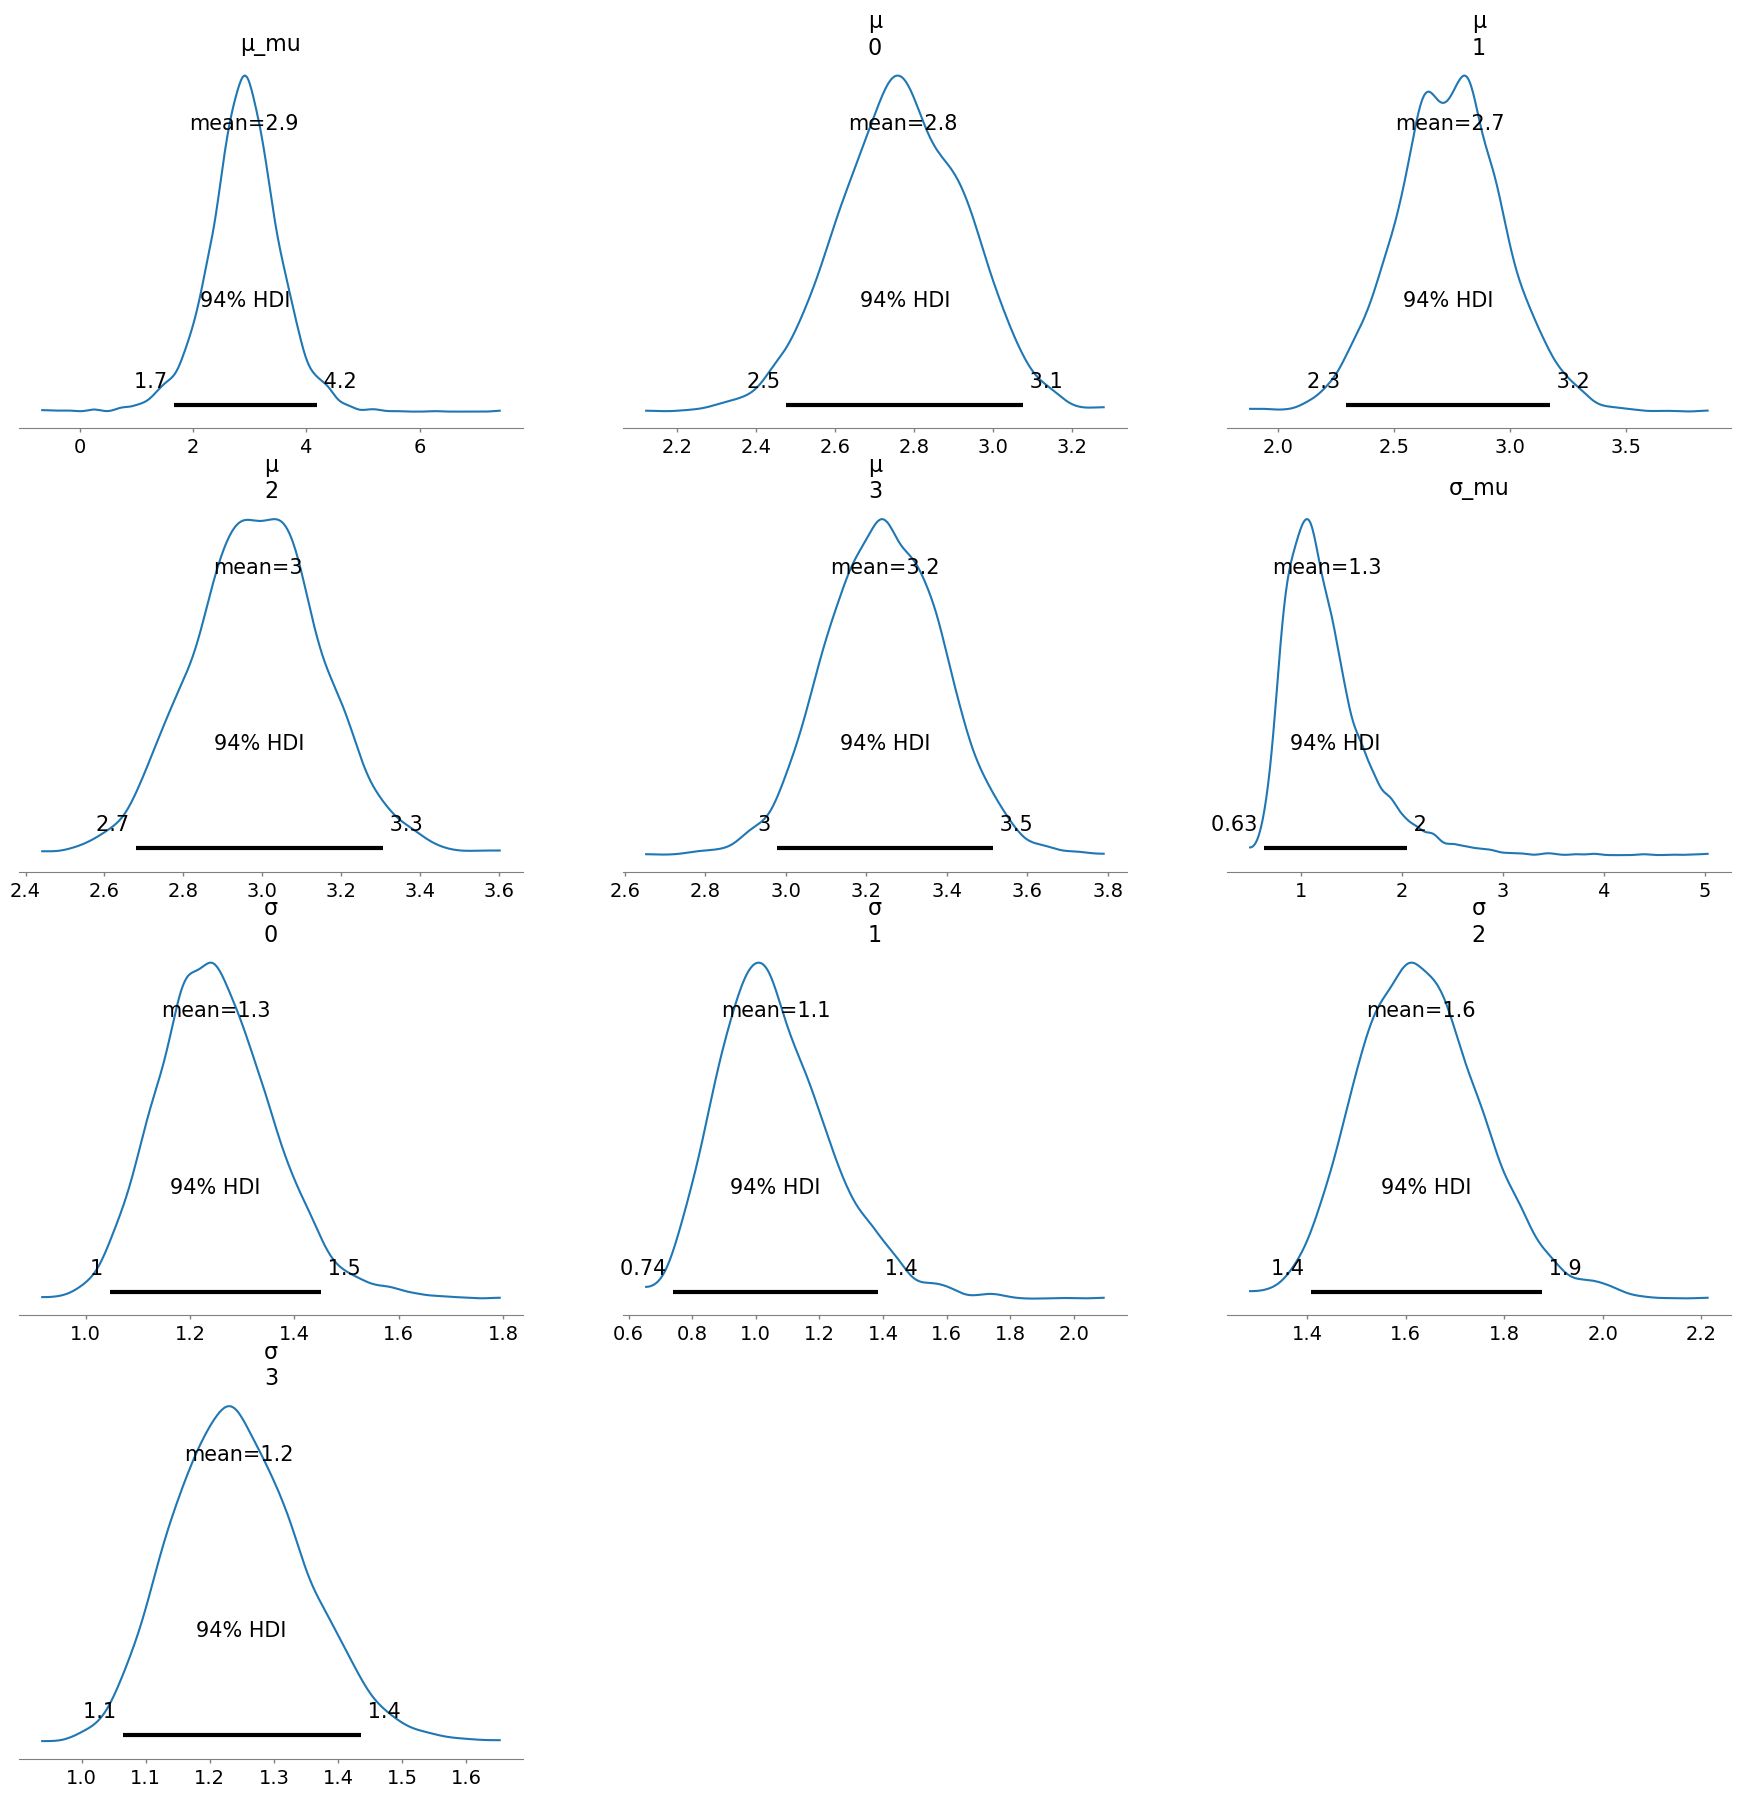

In [46]:
az.plot_posterior(idata)

In [18]:
with tips_h:
    idata.extend(pm.sample_posterior_predictive(idata,model=tips_h))

Sampling: [y]


Output()

array([<Axes: xlabel='y\nSun'>, <Axes: xlabel='y\nSat'>,
       <Axes: xlabel='y\nThur'>, <Axes: xlabel='y\nFri'>], dtype=object)

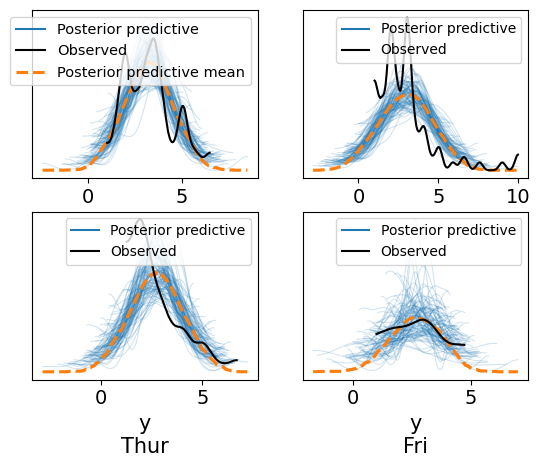

In [26]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(2, 2) 
az.plot_ppc(idata, num_pp_samples=100, 
            coords={"days_flat":[categories]}, flatten=[], ax=axes)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [19]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [39]:
with pm.Model() as comparing_groups: 
    μ = pm.Normal("μ", mu=0, sigma=10, shape=4) 
    σ = pm.HalfNormal("σ", sigma=10, shape=4) 
 
    y = pm.Normal("y", mu=μ[idx], sigma=σ[idx], observed=tip)

    idata_nh=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


array([[<Axes: title={'center': 'μ\n0'}>,
        <Axes: title={'center': 'μ\n1'}>,
        <Axes: title={'center': 'μ\n2'}>,
        <Axes: title={'center': 'μ\n3'}>],
       [<Axes: title={'center': 'σ\n0'}>,
        <Axes: title={'center': 'σ\n1'}>,
        <Axes: title={'center': 'σ\n2'}>,
        <Axes: title={'center': 'σ\n3'}>]], dtype=object)

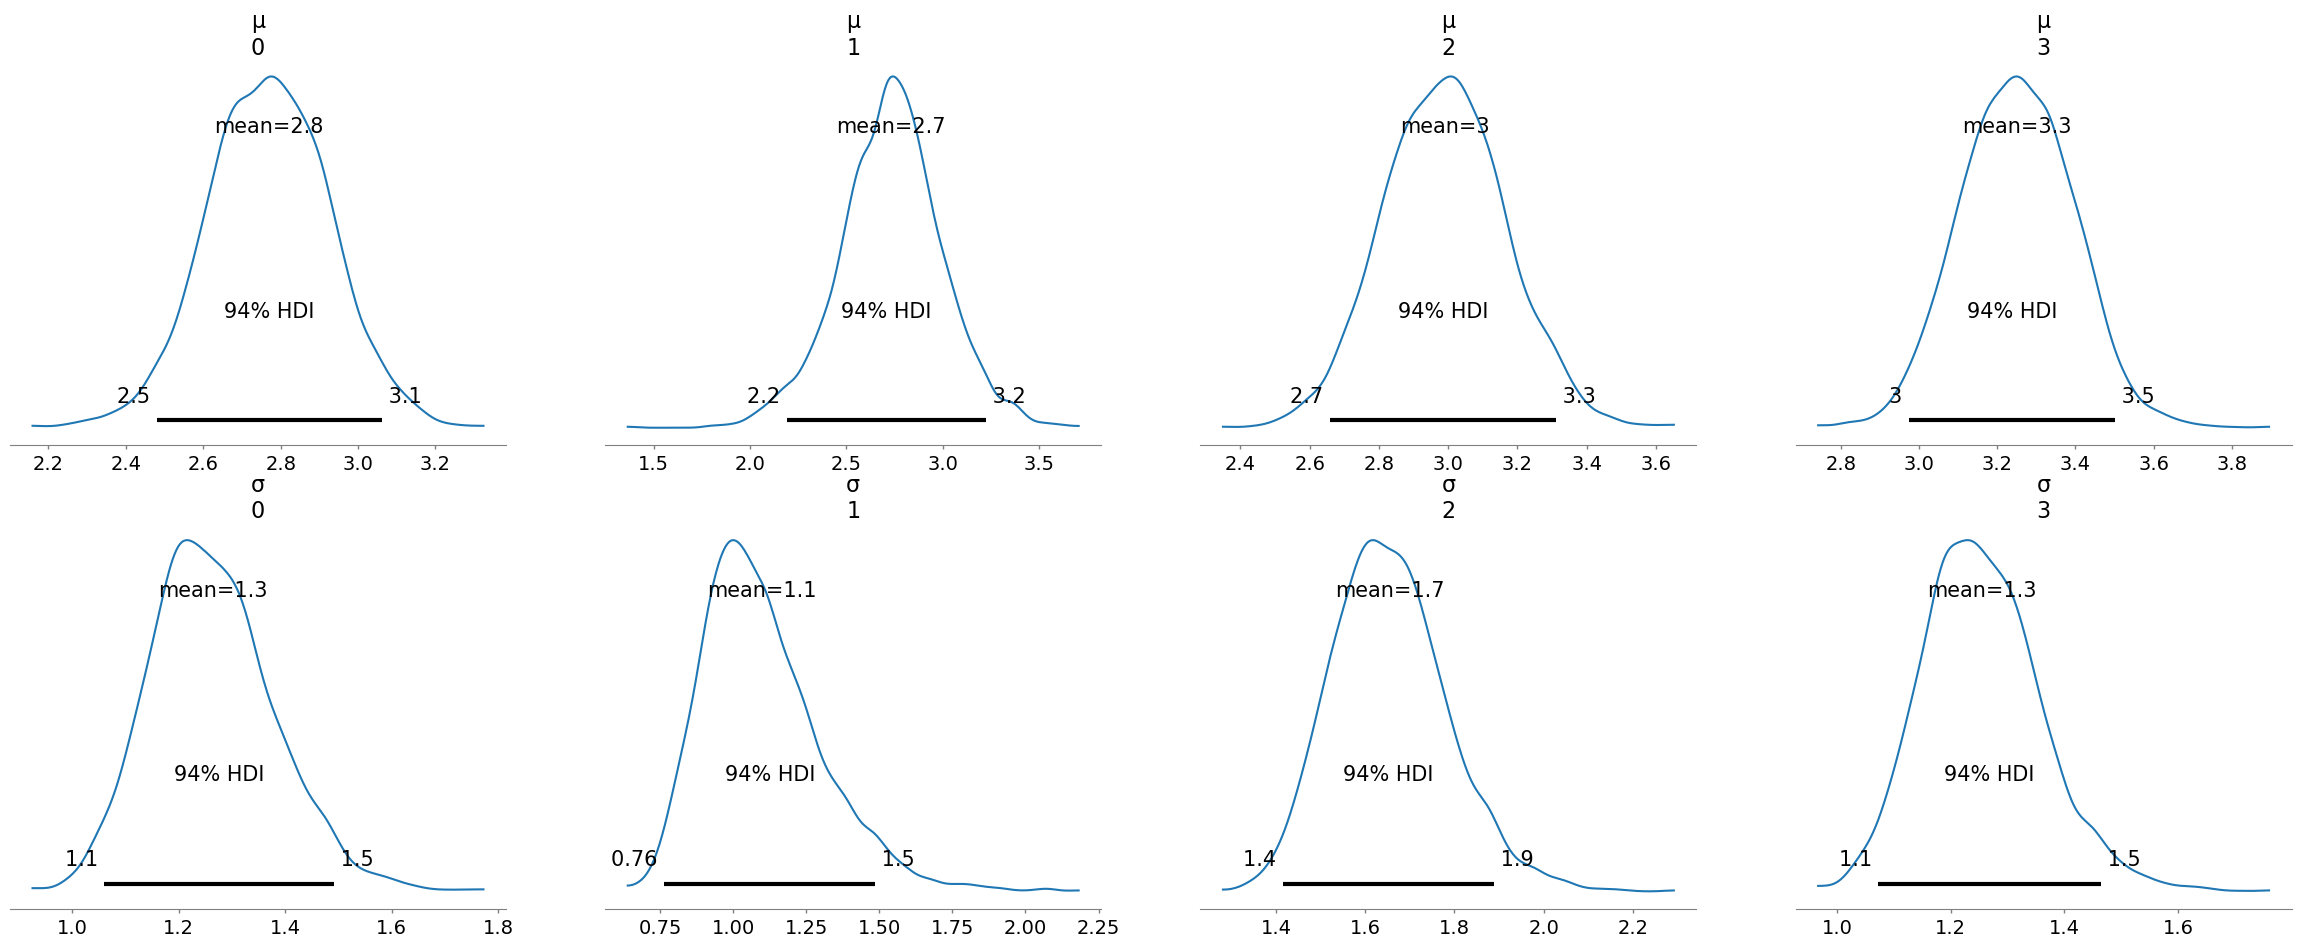

In [40]:
az.plot_posterior(idata_nh)